<a href="https://colab.research.google.com/github/BaibhavSureka/CODSOFT/blob/main/Task3__image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)


python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
keras version 2.15.0
tensorflow version 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#photos
dir_Flickr_jpg = dir_Flickr_jpg = "/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/"

dir_Flickr_text = dir_Flickr_text = r"/content/drive/MyDrive/ImageCaptioning/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [ ]:
import pandas as pd
from collections import Counter

## caption
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1 or col[0] == '':
        continue
    w = col[0].split("#")
    datatxt.append([w[0], w[1], col[1].lower()])

# Create DataFrame
df_txt = pd.read_csv("/content/drive/MyDrive/ImageCaptioning/captions.txt")
# Debugging prints
print("First few rows of df_txt:")
print(df_txt.head())

uni_filenames = np.unique(df_txt["image"].values)
print("The number of unique file names: {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
print(Counter(Counter(df_txt["image"].values).values()))

First few rows of df_txt:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
The number of unique file names: 8091
The distribution of the number of captions for each image:
Counter({5: 8091})


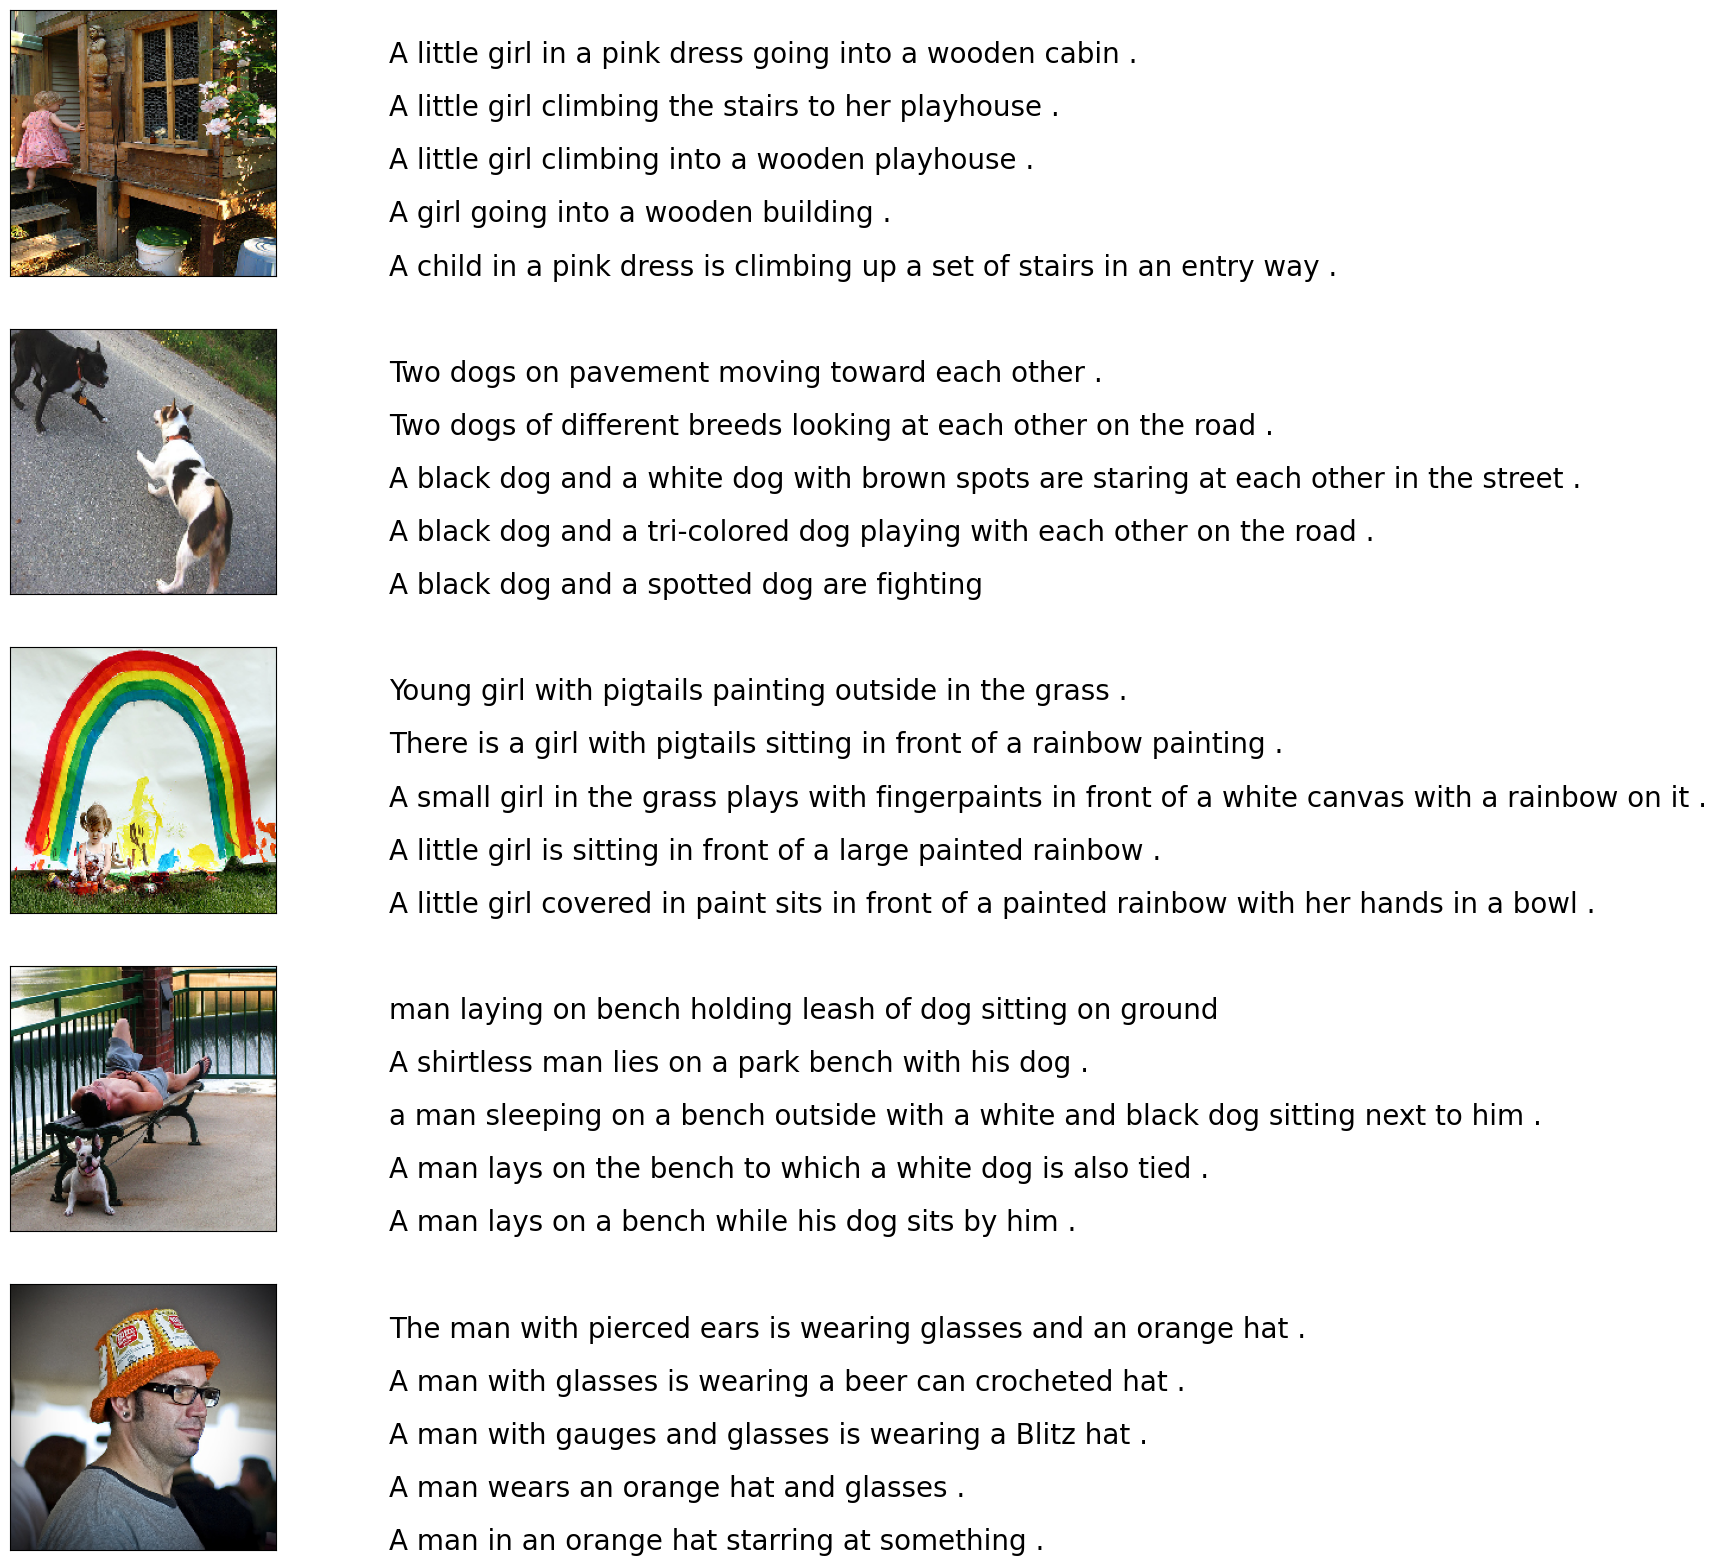

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

npic = 5
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10, 20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["image"] == jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()


In [ ]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    dfword.sort_values(by='count', ascending=False, inplace=True)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 9630


,word,count
0,a,40319
1,.,36577
2,A,22667


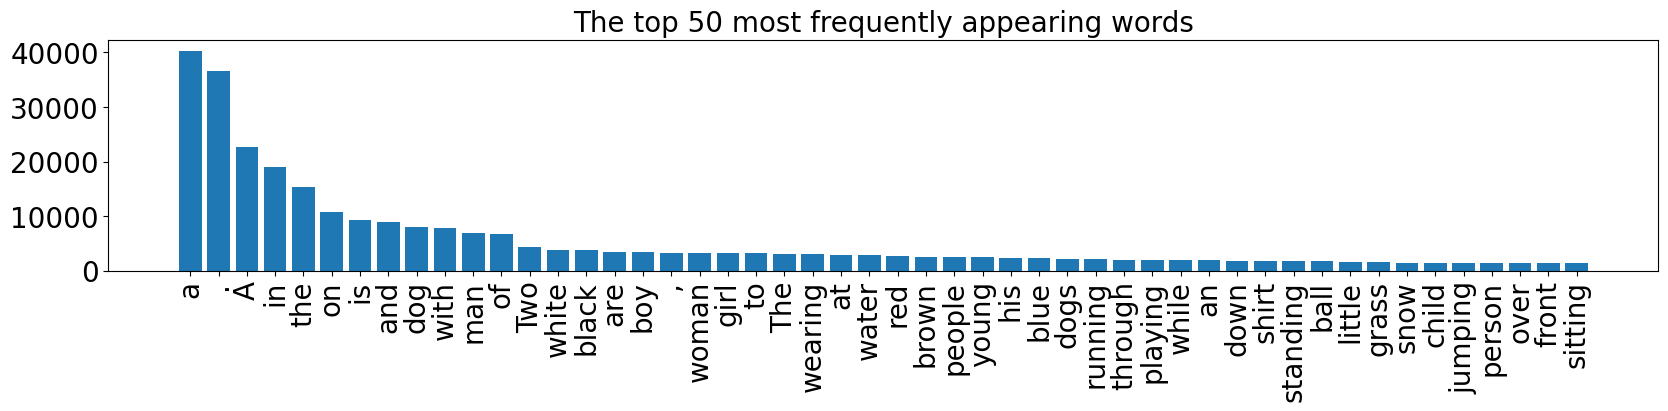

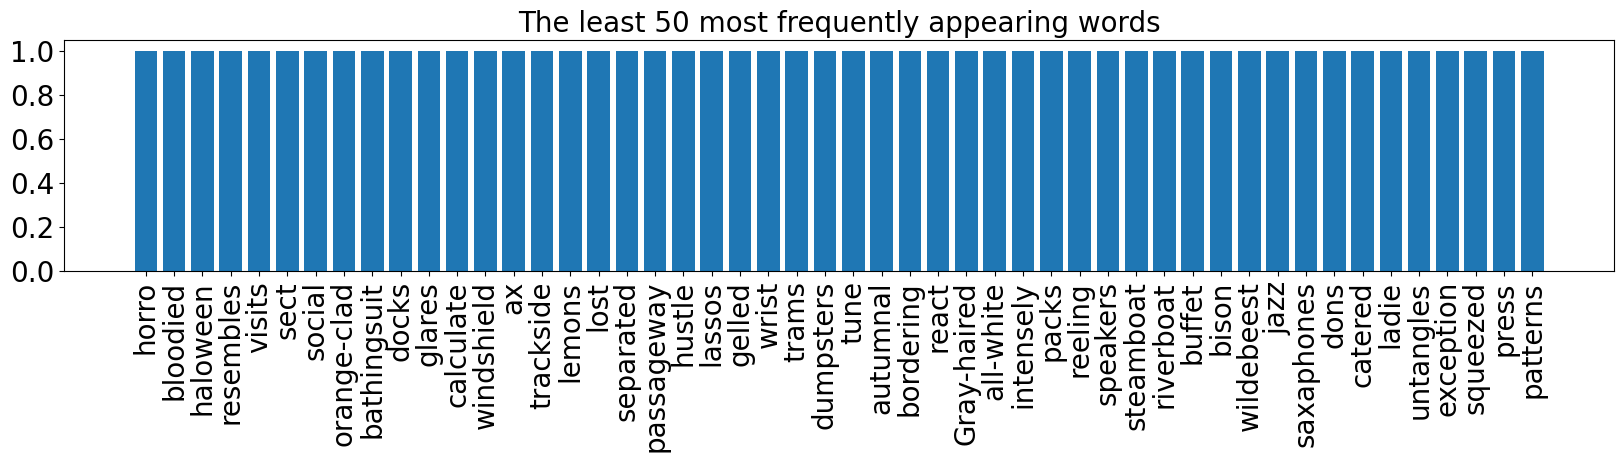

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
import string
text_original = "I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?

Remove punctuations..
I scored 21 in NLP but Akshat topped I have python v38 Its 420 pm Could you give us 20 on 20

Remove a single character word..
 scored 21 in NLP but Akshat topped have python v38 Its 420 pm Could you give us 20 on 20

Remove words with numeric values..
    scored     : True
    21         : False
    in         : True
    NLP        : True
    but        : True
    Akshat     : True
    topped     : True
    have       : True
    python     : True
    v38        : False
    Its        : True
    420        : False
    pm         : True
    Could      : True
    you        : True
    give       : True
    us         : True
    20         : False
    on         : True
    20         : False
 scored in NLP but Akshat topped have python Its pm Could you give us on
